In [ ]:
# ===============================================================
# ANÁLISIS CLIMÁTICO AUTOMÁTICO – ECUADOR / GLOBAL (ERA5 / NetCDF)
# Autor: Santiago Jumbo
# Descripción: Carga, analiza y visualiza temperatura 2m (ERA5 )
# ===============================================================

In [127]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import pandas as pd
from datetime import datetime

In [128]:

ruta = "/home/jovyan/prueba/daab146598a5037cd0198de50a22e787.nc"  
ds = xr.open_dataset(ruta)

# Detectar variable principal
var = list(ds.data_vars.keys())[0]
data = ds[var]
print(f"📦 Variable detectada: {var}")

# Convertir Kelvin → °C si aplica
if float(data.max()) > 200:
    data = data - 273.15
    print("🌡️ Datos convertidos a °C")

📦 Variable detectada: t2m
🌡️ Datos convertidos a °C


In [129]:

#  Identificar coordenadas

lat_name = [c for c in data.coords if "lat" in c.lower()][0]
lon_name = [c for c in data.coords if "lon" in c.lower()][0]
tiempo = [c for c in data.dims if "time" in c.lower() or "valid_time" in c.lower()][0]

# Ajustar longitudes de 0–360 a -180–180
if data[lon_name].max() > 180:
    data = data.assign_coords({lon_name: (((data[lon_name] + 180) % 360) - 180)})
    data = data.sortby(lon_name)

In [135]:
# Seleccionar Región
lat_min, lat_max = -6, 3
lon_min, lon_max = -92, -74
ecuador = data.sel({lat_name: slice(lat_min, lat_max), lon_name: slice(lon_min, lon_max)})

validos = np.isfinite(ecuador.values).sum()


In [132]:
# ---------------------------------------------------------------
# Estadísticas básicas
# ---------------------------------------------------------------
mean_series = ecuador.mean(dim=[lat_name, lon_name], skipna=True)
mean_map = ecuador.mean(dim=tiempo, skipna=True)

def safe_stat(arr, func, label):
    try:
        val = float(func(arr, skipna=True).values)
        print(f"{label}: {val:.2f} °C")
        return val
    except Exception:
        print(f"{label}: sin datos válidos")
        return np.nan

print("\n=== ESTADÍSTICAS ===")
promedio = safe_stat(ecuador, lambda x, **_: x.mean(**_), "Promedio")
maximo = safe_stat(ecuador, lambda x, **_: x.max(**_), "Máximo")
minimo = safe_stat(ecuador, lambda x, **_: x.min(**_), "Mínimo")

# Guardar estadísticas
stats_df = pd.DataFrame({
    "Variable": [var],
    "Promedio (°C)": [promedio],
    "Máximo (°C)": [maximo],
    "Mínimo (°C)": [minimo],
    "Fecha análisis": [datetime.now().strftime("%Y-%m-%d %H:%M")]
})
stats_df.to_csv("/home/jovyan/prueba/estadisticas_ecuador.csv", index=False)
print(" Estadísticas exportadas → estadisticas_ecuador.csv")


=== ESTADÍSTICAS ===
Promedio: 22.87 °C
Máximo: 28.58 °C
Mínimo: 5.50 °C
 Estadísticas exportadas → estadisticas_ecuador.csv


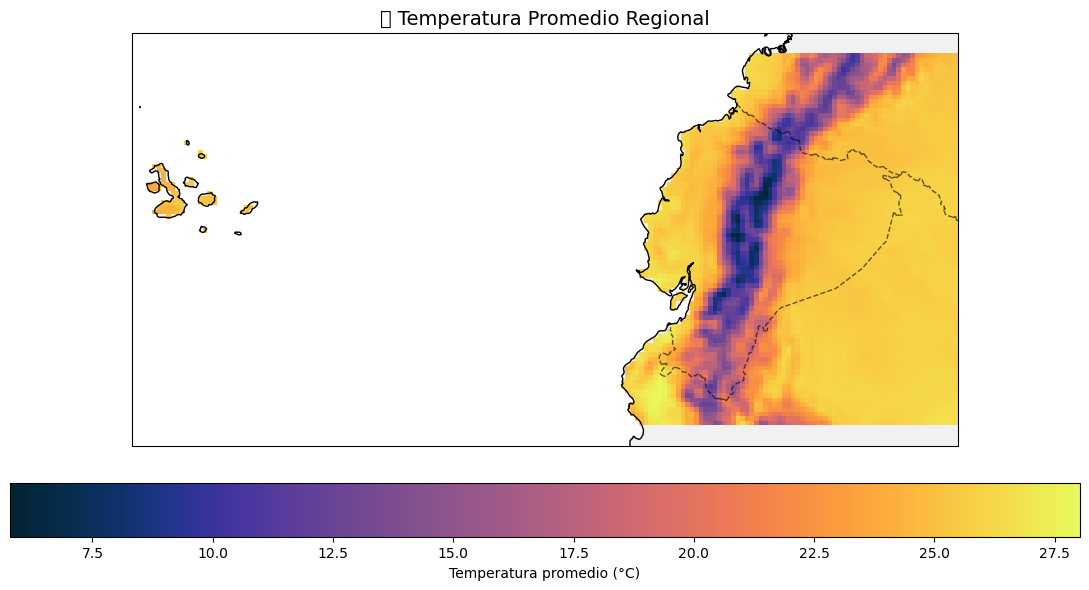

In [137]:
# ---------------------------------------------------------------
# MAPA PROMEDIO
# ---------------------------------------------------------------
plt.figure(figsize=(11,6))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

p = mean_map.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal, add_colorbar=False
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.coastlines(resolution="10m", color="black")
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.6)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
cb = plt.colorbar(p, orientation="horizontal", pad=0.07)
cb.set_label("Temperatura promedio (°C)")
plt.title("🌎 Temperatura Promedio Regional", fontsize=14)
plt.tight_layout()
plt.savefig("/home/jovyan/prueba/mapa_promedio.png", dpi=200)
plt.show()

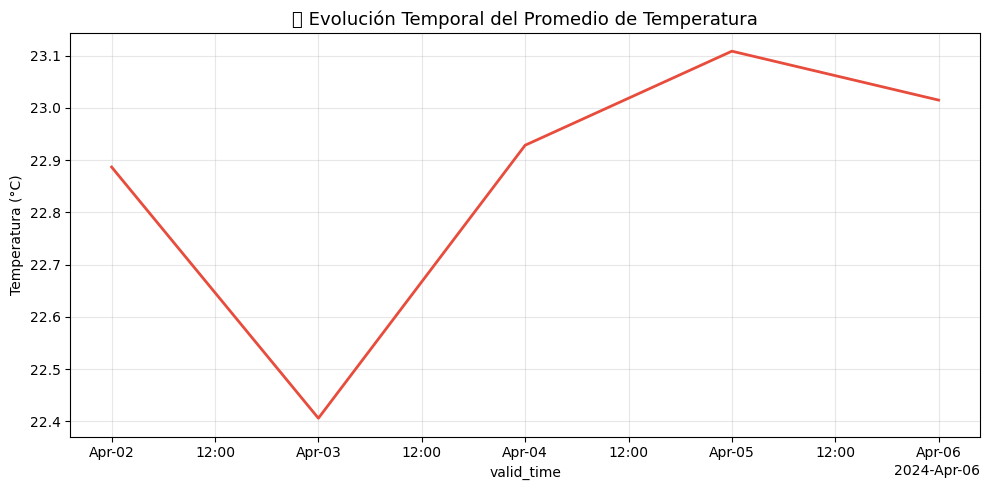

In [139]:
# ---------------------------------------------------------------
# SERIE TEMPORAL PROMEDIO
# ---------------------------------------------------------------
if tiempo in mean_series.dims:
    plt.figure(figsize=(10,5))
    mean_series.plot(color="#E74C3C", linewidth=2)
    plt.title("📈 Evolución Temporal del Promedio de Temperatura", fontsize=13)
    plt.ylabel("Temperatura (°C)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("/home/jovyan/prueba/serie_temporal.png", dpi=200)
    plt.show()

